<center>
  <img src="https://cdn1.i-scmp.com/sites/default/files/styles/2000x792/public/topics/2015/09/10/beijing_air_pollution.jpg?itok=ViKGSy0X">
  <h1>
    <b>
      Solving Beijing's Pollution Crisis Through Analysis of Energy Production
    </b>
  </h1>
  <h3>Brandon Kocur, Shashank Polanki</h3>
</center>
  <hr>
<center>
  <h1>
    <b>
      Introduction
    </b>
  </h1>
</center>

<p>Beijing has been suffering from very poor air quality for quite some time. The huge city of 21.54 million people has been breathing air contaminated with small particles output from the industrialized city.  We have undertaken the task to determine which areas of their energy production industry are causing the air pollution to worsen, and by how much. For some more historical context on this serious issue, <a href="https://www.reuters.com/article/us-china-pollution-beijing/chinas-capital-beijing-vows-air-quality-improvement-but-gives-no-target-idUSKCN1Q90TU">this article</a> from Reuters has you covered.</p>
<p>There are many factors to considering when describing air as "polluted", but in this analysis, we will be solely looking at PM<sub>2.5</sub> concentration. According to <a href="https://blissair.com/what-is-pm-2-5.htm">a writeup about PM<sub>2.5</sub> by Bliss Air</a>, "PM<sub>2.5</sub> refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair." The article goes onto explain that these particles are light enough to stay airborne for long periods of time, and small enough to lodge themselves deep into our lungs. They can be very harmful to human respiratory systems and can cause heart and lung disease in the long term.</p>
<p>Thankfully, data science can save us all! With the abundance of pollution readings, weather data, and energy output, we can pinpoint the epicenter of the air pollution crisis. We will first project trends in PM<sub>2.5</sub> concentration, and then analyze which energy sources are causing the most issues so that we can make a recommendation to the Beijing government. To give merit to our recommendation, we will be looking at the effects of 9 major energy sources and an analysis of the weather.</p>
<hr>
<center>
  <h1>
    <b>
      Gathering the Data and Tools
    </b>
  </h1>
</center>
<p>
All code is writen in Python 3. The libraries we used: <a href="https://pandas.pydata.org/pandas-docs/stable/">pandas</a>, <a href="https://docs.scipy.org/doc/numpy/user/">numpy</a>, <a href="https://matplotlib.org/contents.html">matplotlib</a>, <a href="http://scikit-learn.org/stable/documentation.html">scikit-learn</a>, <a href="https://seaborn.pydata.org/">seaborn</a>, <a href="https://www.statsmodels.org/stable/index.html">statsmodels</a>, <a href="https://docs.python.org/3/library/math.html">math</a>
</p>



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import datetime
import matplotlib
import math
import statsmodels.api as sm
import sklearn
from sklearn import datasets, linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict

# Ensuring All Columns Are Displayed In The Dataframes
pd.set_option('display.max_columns', None)

<h2><b>Reading the pollution data</b></h2>
<p>Little modification was done to this data. The 'No' column was dropped because we can just use the panda dataframe index. Some of the entries had a missing PM2.5 value. These rows are useless to us and were dropped. Thankfully, most of the data was complete so not enough data was lost to require compensation.</p>

In [0]:
# read the data into a pandas dataframe
data = pd.read_csv("https://github.com/jbrownlee/Datasets/raw/master/pollution.csv")
df_pollution = data.drop(columns=['No'])
df_pollution.dropna(subset=['pm2.5'], inplace=True)
df_pollution.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<h2><b>Reading the energy consumption data</b></h2>
<p>The energy consumption data was pulled from the National Bureau of Statistics of China. It was a bit ill-formatted and required the insertion of 'NA' values anywhere there was a blank cell. This allowed proper parsing for the pandas <code>read_csv()</code> function. The data was also organized horizontally, and required a transpose for <code>read_csv()</code> to read it. Both the aforementioned modifications were done in Microsoft Excel.</p>
<h2><b>Tidying the energy consumption data</b></h2>
<p>The original data had very long variable names such as, "Consumption of Coal(10000 tons)". The variable names were shorted for the sake of programming ease and style. The units for each type of energy are moved to a new column.
<p>In order to match the time window of the pollution data, only the years 2010 to 2014 are used. Now that the data is appropriately imported and formatted, we complete its preparation by melting the data with respect to the year via <code>melt(id_vars=['year'])</code></p>

In [0]:
# read the data into a pandas dataframe
data = pd.read_csv("https://raw.githubusercontent.com/Brandoko/Brandoko.github.io/master/BeijingEnergyConsumption.csv")
df_energy = data.loc[(data['Indicators'] >= 2010) & (data['Indicators'] <= 2014)].copy()
# shorten the column names
df_energy.rename(columns={'Indicators':'year', 'Consumption of Coal(10000 tons)':'coal', 
                            'Consumption of Coke(10000 tons)':'coke', 'Consumption of Crude Oil(10000 tons)':'crude_oil', 
                            'Consumption of Gasoline(10000 tons)':'gasoline', 'Consumption of Kerosene(10000 tons)':'kerosene', 
                            'Consumption of Diesel Oil(10000 tons)':'diesel_oil', 'Consumption of Fuel Oil(10000 tons)':'fuel_oil', 
                            'Consumption of Natural Gas(100 million cu.m)':'natural_gas', 'Consumption of Electricity(100 million kwh)':'electricity'}, inplace=True)
# melt the data
df_energy = df_energy.melt(id_vars=['year'])
# define a dictionary that will be used to assign to appropriate unit for each energy type
unit_dic = {'coal':'10000 tons', 'coke':'10000 tons', 'crude_oil':'10000 tons', 
                            'gasoline':'10000 tons)', 'kerosene':'10000 tons', 
                            'diesel_oil':'10000 tons', 'fuel_oil':'10000 tons', 
                            'natural_gas':'100 million cu.m', 'electricity':'100 million kwh'}
# add a new column for unit
df_energy['unit'] = ''
# iterate through and fill in the unit value for each entry according to the dictionary
for i in df_energy.index:
  df_energy.at[i, 'unit'] = unit_dic[df_energy['variable'][i]]
  
df_energy.rename(columns={'variable':'energy_type'}, inplace=True)
df_energy.head(10)

,year,energy_type,value,unit
0,2014,coal,1736.54,10000 tons
1,2013,coal,2019.23,10000 tons
2,2012,coal,2270.00,10000 tons
3,2011,coal,2366.00,10000 tons
4,2010,coal,2634.62,10000 tons
5,2014,coke,0.64,10000 tons
6,2013,coke,0.79,10000 tons
7,2012,coke,32.27,10000 tons
8,2011,coke,33.28,10000 tons
9,2010,coke,220.45,10000 tons


<hr>
<center>
  <h1>
    <b>
      Exploratory Data Analysis
    </b>
  </h1>
</center>
<p>All our data is nicely named and formatted! Now it's time to start looking at the data itself. In this section we will visualize the data and observe the trends so that we can get an idea of what features we might end up using in the machine learning model</p>
<h2><b>Where is PM2.5 trending?</b></h2>

Text(0.5, 1.0, 'Year vs PM2.5 Regression')

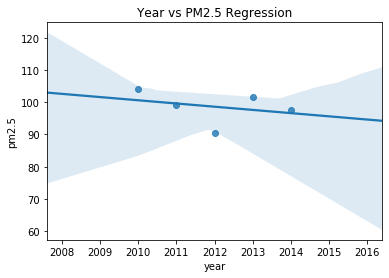

In [0]:
# combine the year, month, and day column values into one date column for future use. Data type is datetime.
df_pollution['date'] = '-'
for i in df_pollution.index:
  df_pollution.at[i, 'date'] = datetime.datetime(df_pollution['year'][i], df_pollution['month'][i], df_pollution['day'][i])
# before graphing we will aggregate the data so that the yearly averages of PM2.5 are used
df_pollution_avg_by_date = df_pollution.groupby('year').mean().reset_index()
# next, we plot year against pm2.5 using regplot to see the line of best fit
sns.regplot(df_pollution_avg_by_date['year'], df_pollution_avg_by_date['pm2.5'])
plt.title("Year vs PM2.5 Regression")

<p>Above is a projected trend in the PM2.5 concentration. Beijing's latest efforts have led to a decreasing trend, but it is still significantly higher than what The World Health Organization recommends. The target is 10 micrograms per cubic meter. Beijing only just recently made it below 100ug/cubic meter. Later on, we will attempt to determine which area of energy production has had the most prominent effect in lowering the PM2.5 and make recommendations of where to shift energy production.</p>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

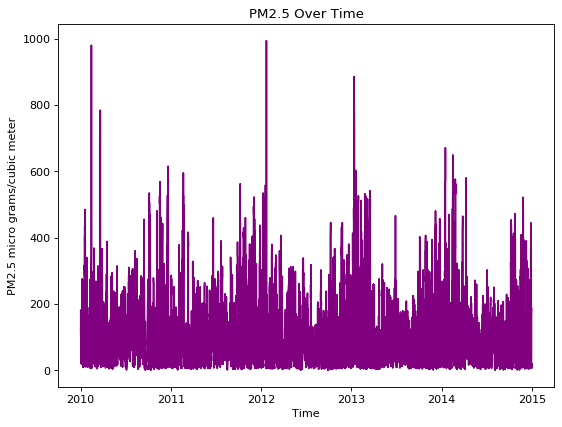

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.plot(df_pollution['date'], df_pollution['pm2.5'], color='purple')
plt.title('PM2.5 Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5 micro grams/cubic meter')

This figure shows us the actual hourly readings of PM2.5 over our entire analysis period. An interesting point to note is that the pollution seems to spike at the turn of every year. This may be related to temperature, climate, peak factory periods, or something else entirely. Lets try to uncover this as we explore the data.

<h2><b>Trends: Consumption of major energy products</b></h2>
<p>Below are graphs displaying the trends in the consumption of coal, coke, crude oil, gasoline, kerosene, diesel oil, fuel oil, natural gas, and electricity. We can use these trends to determine which one is weighted the most regarding its effect on air pollution.</p>
<p>Let's draw some plots using linear regression lines to visualize the trends, and print the linear regression models for reference.</p>

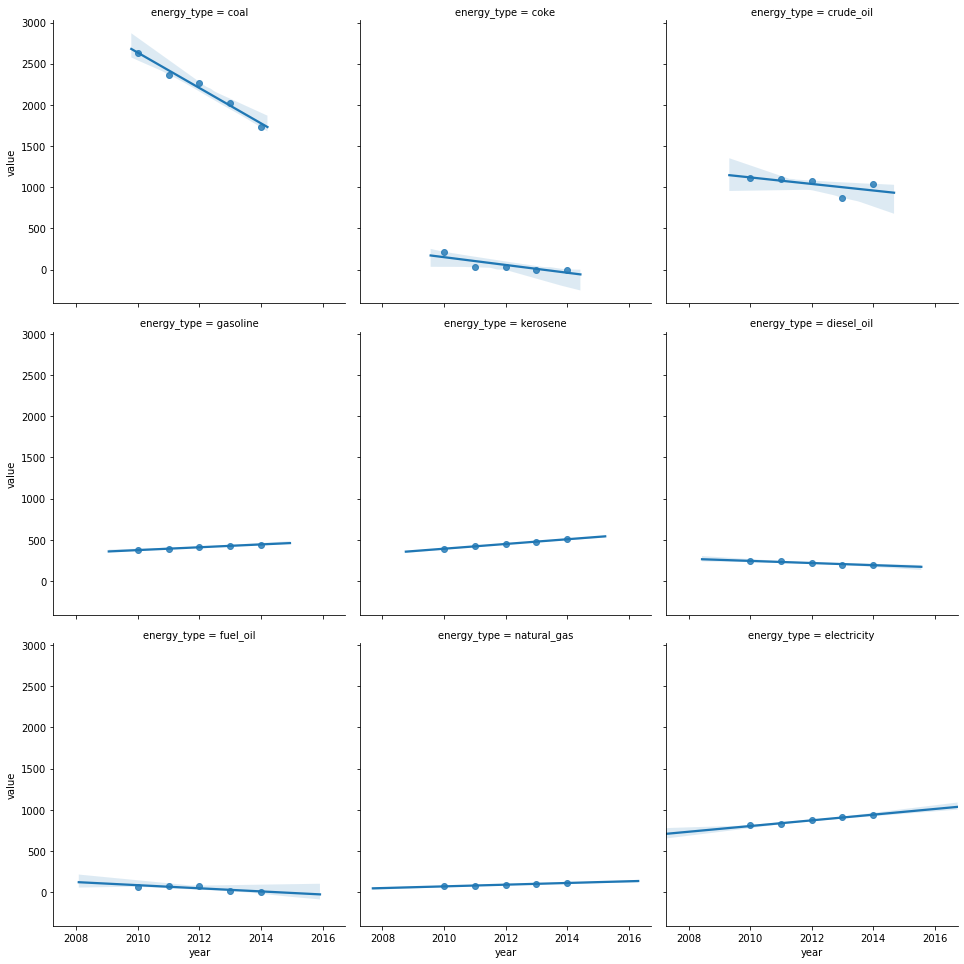

In [0]:
# Create a FacetGrid object that dispalys our plots in a 3x3 layout
g = sns.FacetGrid(df_energy, col='energy_type', col_wrap=3, height=4.5)
# Map the plots using Seaborn's regplot
g.map(sns.regplot, 'year', 'value')

<h3><b>Formulating our regression models</b></h3>
<p>Now lets print out the regression models for each type of energy. This will likely be needed when it comes time to start predicting and analyzing. For easy future reference, we also create a dictionary that stores all the regression models. For example, if we want to get the b (intercept) value for coal, we execute: <code>linreg_dic['coal']['b']</code>. Furthermore, to get the m (slope) value for electricity's model, we can execute: <code>linreg_dic['electricity']['m']</code></p>

In [0]:
print('Linear Regression Formulas For Each Type of Energy: ')
# create a dictionary that will store all of the linear regression models
linreg_dic = {}
# create a list of all our energy types so that we can iterate through it and print each model
energy_list = ['coal', 'coke', 'crude_oil', 'gasoline', 'kerosene', 'diesel_oil', 'fuel_oil', 'natural_gas', 'electricity']
for e in energy_list:
  # create a filtered version of the dataframe that only has columns with 'coal', or 'gassoline', etc.
  df_energy_filter = df_energy[df_energy['energy_type'] == e]
  # use polyfit to create the linear regression model
  b, m = np.polynomial.polynomial.polyfit(df_energy_filter['year'], df_energy_filter['value'], 1)
  print(e, 'y =', m, '* year +', b)
  # add model to dictionary. You can then access the models by linreg_dic['coal']['b'] or linreg_dic['gasoline']['m'] etc.
  linreg_dic[e] = {'b': b, 'm': m}

Linear Regression Formulas For Each Type of Energy: 
coal y = -214.29299999996522 * year + 433362.79399993015
coke y = -47.2109999999868 * year + 95046.01799997347
crude_oil y = -39.74999999998389 * year + 81017.5359999676
gasoline y = 17.199999999996603 * year + -34198.10999999317
kerosene y = 28.70799999999497 * year + -57312.3999999899
diesel_oil y = -12.91399999999697 * year + 26199.91199999391
fuel_oil y = -18.845999999996913 * year + 37964.8359999938
natural_gas y = 10.306999999998386 * year + -20647.097999996757
electricity y = 34.56899999999319 * year + -68681.61599998633


<h2><b>Before we make assumptions, let's look at how weather comes into play</b></h2>
<p>We must identify potential sources of bias before blaming a particular energy source. First, let's take a look at how wind speed affects air pollution.</p>
<h3><b>Wind speed</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

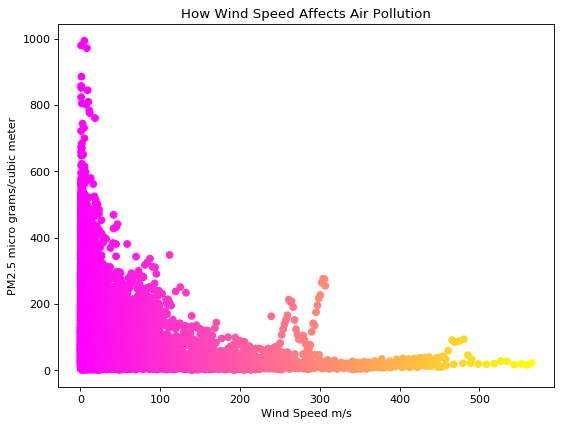

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['Iws'], df_pollution['pm2.5'], c=df_pollution['Iws'], cmap='spring')
plt.title('How Wind Speed Affects Air Pollution')
plt.xlabel('Wind Speed m/s')
plt.ylabel('PM2.5 micro grams/cubic meter')

<p>The scatter plot above shows us that there is a clear-cut relationship between wind speed and pollution. There seems to be an inverse relationship resembling the function y = 1/x. PM2.5 readings taken in conditions with low wind speeds have astronomical PM2.5 readings. These values should be pruned when analyzing for trends. The same goes for readings in high wind speeds.</p>
<h3><b>Rainfall</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

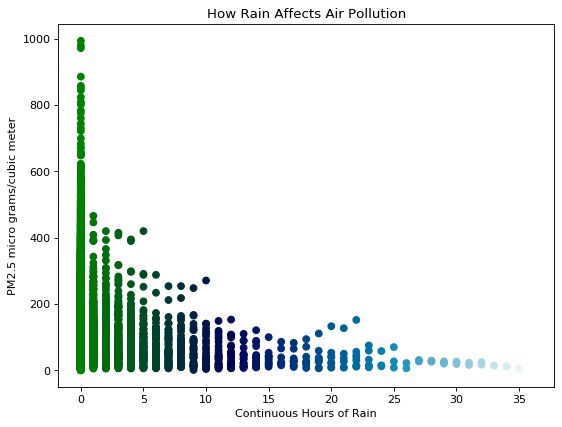

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['Ir'], df_pollution['pm2.5'], c=df_pollution['Ir'], cmap='ocean')
plt.title('How Rain Affects Air Pollution')
plt.xlabel('Continuous Hours of Rain')
plt.ylabel('PM2.5 micro grams/cubic meter')

<p>This scatter plot shows us yet another clear relationship, but this time between rainfall and pollution. This trend is more linear, showing us that more rainfall means lower air pollution. This is to be expected as rain cleans the air. Thankfully, most of the readings have no rainfall, so we can remove all data where rain came into play without impacting the reliability of the data. This will remove bias from precipitation.</p>
<h3><b>Snow</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

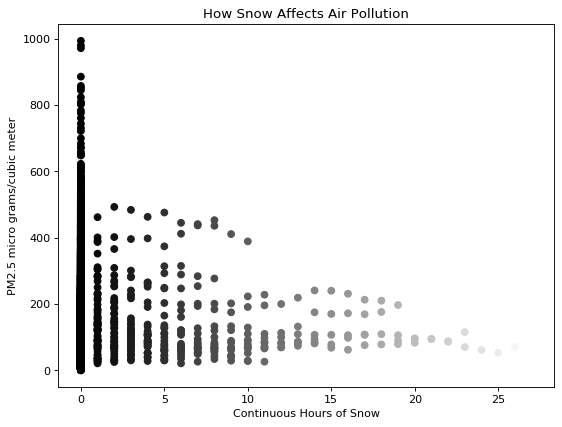

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['Is'], df_pollution['pm2.5'], c=df_pollution['Is'], cmap='gray')
plt.title('How Snow Affects Air Pollution')
plt.xlabel('Continuous Hours of Snow')
plt.ylabel('PM2.5 micro grams/cubic meter')

<p>Snowfall has a very similar looking relationship to rainfall. This is unsurprising considering that they are both forms of precipitation.</p>
<h3><b>Temperature</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

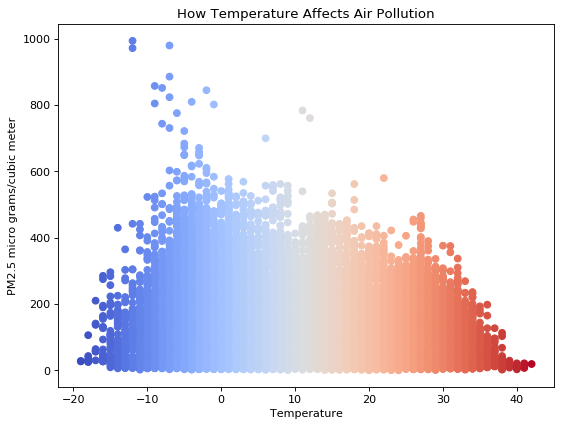

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['TEMP'], df_pollution['pm2.5'], c=df_pollution['TEMP'], cmap='coolwarm')
plt.title('How Temperature Affects Air Pollution')
plt.xlabel('Temperature')
plt.ylabel('PM2.5 micro grams/cubic meter')

<p>Next, we wanted to see if temperature had any meaningful effect on pollution readings. From the plot above, it appears that there is no noticeable relationship, given that it represents a bell curve; although this could be something worth taking note of. Because of this, we don't have to worry about temperature throwing off our estimations.</p>
<h3><b>Dew Point</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

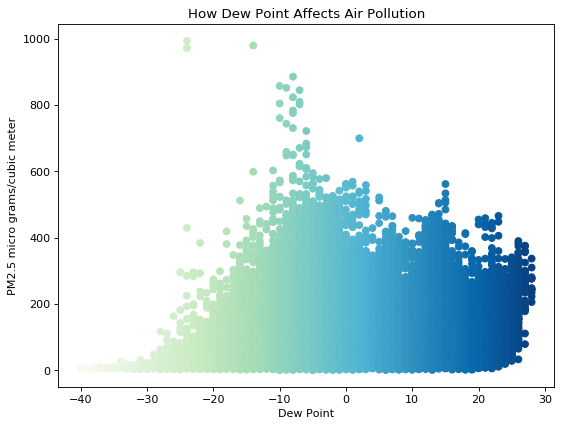

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['DEWP'], df_pollution['pm2.5'], c=df_pollution['DEWP'], cmap='GnBu')
plt.title('How Dew Point Affects Air Pollution')
plt.xlabel('Dew Point')
plt.ylabel('PM2.5 micro grams/cubic meter')

This plots hints that dew point readings closer to -10 C<sup>o</sup> tend to have higher air pollution values, but the relation is weak and most likely the result of most readings having dew points between -10 C<sup>o</sup> and 20 C<sup>o</sup>. This relationship will be ignored.
<h3><b>Air Pressure</b></h3>

Text(0, 0.5, 'PM2.5 micro grams/cubic meter')

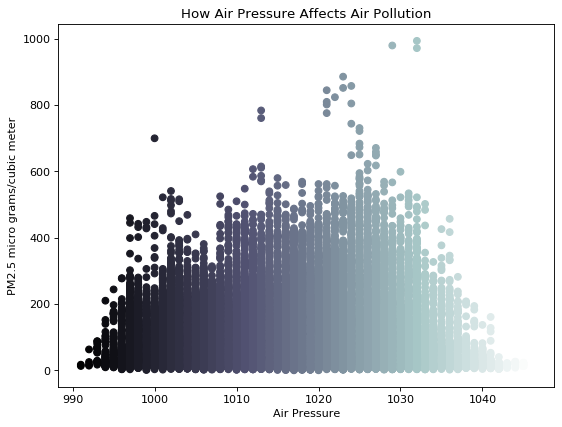

In [0]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(df_pollution['PRES'], df_pollution['pm2.5'], c=df_pollution['PRES'], cmap='bone')
plt.title('How Air Pressure Affects Air Pollution')
plt.xlabel('Air Pressure')
plt.ylabel('PM2.5 micro grams/cubic meter')

Finally, we concluded our weather analysis with air pressure data. Much like temperature, there is no descernable trend here.
<h3><b>Weather Analysis Conclusion</b></h3>
<p>It has now been determined that wind speed and precipitation have a significant effect on PM2.5 readings. When we train our machine learning model to identify the most harmful energy sources, we should keep the weather in mind and trim the data accordingly. Removing the extremely fast and very slow wind readings is recommended. Removing entries with precipitation is recommended as well.</p>

<hr>
<center>
  <h1>
    <b>
      Predicting How the Reduction of Certain Energy Sources Will Clean the Air 
    </b>
  </h1>
</center>
<p>Now we know which energy sources are being phased in and out, and by how much. In this section we will demonstrate how to train a predictive machine learning model to estimate the level of pollution in Beijing on a given day based on weather and energy output factors to identify which features have the highest weight.</p>
<p>
  Things start to get heavy in statistics here. If you get lost or have trouble following our code, you can look <a href="https://www.dataquest.io/blog/sci-kit-learn-tutorial/">here for a good example of the machine learning process.</a> That example and our project use sklearn which you can learn more about <a href="https://scikit-learn.org/stable/">here</a>. Experienced readers may find its documentation very useful to expand beyond what we did.
</p>
<h2><b>Setting Up Data For ML/Multi-Variariate Regression Analysis</b></h2>
<p>Before getting started, we have to process the pollution's dataframe and the energy output dataframe to ultimately combine these two into a single dataframe.
</p>
<p><b>Steps To Take:</b></p>
<ul>
  <li>Take the pollution's dataframe and aggregate it by days rather than hours to cut down on the size of the dataframe.</li>
  <li>Normalize the pollution levels by taking the log of the values in the column to help with improving the accuracy of our potential model.</li>
  <li>Take the energy output dataframe and divide energy outputs by 365 in order to represent the energy output per day.</li>
  <li>Merge the daily energy outputs by year to the pollution's dataframe but
      make the outputs go in the direction in which the next year's pollution  will be at (this is to account for the limited annual Beijing energy output data that is publicly available)</li>

</ul>


In [0]:
# Group df_pollution by month and day
dfp_daily = df_pollution.groupby(['year', 'month', 'day']).mean().reset_index()
# Normalize daily pollution measurement to help with machine learning accuracy
dfp_daily["pm2.5"] = dfp_daily["pm2.5"].apply(lambda x: math.log(x))
# Get daily energy output 
dfe_daily = df_energy.copy() 
# print(dfe_daily)
dfe_daily['value'] = dfe_daily['value'].apply(lambda x: x/365)

In [0]:
# Go through pollution dataframe and for each day figure out how much of an
# energy resource was outputted on average with a directional adjustment.
resource_map =  {
    "coal": [],
    "coke": [],
    "crude_oil": [],
    "gasoline": [],
    "diesel_oil": [],
    "fuel_oil": [],
    "natural_gas": [],
    "electricity": []
}

# Storing the results of queries to speed up processing
cache_map = {}

# Iterating all rows of the pollution dataframe
for i, row in dfp_daily.iterrows():
  year = row["year"]
  for res in resource_map.keys():
    if year != 2014:
      # Check if curr year and next year's output for a resource is in cache.
      try:
        curr_yr_out = cache_map[(year, res)]
      except KeyError:
        curr_yr_out = list(dfe_daily[(dfe_daily['year'] == year) & 
                          (dfe_daily['energy_type'] == res)]["value"])[0]
        cache_map[(year, res)] = curr_yr_out

      try:
        next_yr_out = cache_map[(year+1, res)]
      except KeyError:
        next_yr_out = list(dfe_daily[(dfe_daily['year'] == year+1) & 
                          (dfe_daily['energy_type'] == res)]["value"])[0]
        cache_map[(year, res)] = next_yr_out
      
      # Adjust the daily output to reflect the direction it grows in
      day_num = row["month"] * row["day"]
      adj_output = curr_yr_out + (next_yr_out - curr_yr_out)/365 * day_num
      resource_map[res].append(adj_output)
    else:
      resource_map[res].append(None)

# Add in all the resources as series to dfp_daily
for k,v in resource_map.items():
  dfp_daily[k] = pd.Series(v)

# Not using data from 2014 since 2014 data has no indication of what direction
# to move in.
dfp_daily = dfp_daily[dfp_daily["year"] < 2014]


<h2><b>Testing the strength of a Multi-Variate Regression Model</b></h2>
<p> We will use sklearn to train a multiple linear regression model to take in our feature set and predict the pollution level. 
Once the model is built, we will analyze is prediction strength. 
</p>

In [0]:
x = ['DEWP', 'TEMP', 'PRES', 'Iws',
     'Is', 'Ir', 'coke', 'crude_oil', 'gasoline', 'diesel_oil',
     'fuel_oil', 'natural_gas', 'electricity']
y = 'pm2.5'
reg = LinearRegression().fit(dfp_daily[x], dfp_daily[y])
fit_score = reg.score(dfp_daily[x], dfp_daily[y])

print("R^2:", fit_score)

R^2: 0.4753566926371605


<p>Although the correlation coefficient is not as strong as it could be, it does indicate that there is a possibility of a predictive relationship between our set of features and the pollution levels. We will further explore this by seeing if a training dataset can predict the pollution levels of the validation dataset.</p>

<h2><b>Training/Validating Multi-Variate Regression Model</b></h2>
<p>Splitting up the data into two pools: 70% of it into the training dataset and 30% of it into the validation dataset to see how accurately the model predicts on validation data</p>

In [0]:
# Create a training set with 70% of the data and testing set with 30% data
x_train, x_test, y_train, y_test = train_test_split(dfp_daily[x], dfp_daily[y],
                                                    test_size=0.3, 
                                                    random_state=7)
reg = linear_model.LinearRegression()
model = reg.fit(x_train, y_train)
print("Score:", model.score(x_test, y_test))


Score: 0.5188608914125545


<p>Fortunately, it seems that the in this instance the model's score is above 50% which for simplicity could be interpreted as that the trained model accurately predicts the validation dataset or at least is nearby the dataset 50% of the time.</p>

<h2><b>Cross-Validating Multi-Variate Regression Model</b></h2>
<p>Although one instance of a 70/30% split yielded a notable score of 0.51, other instances of the datasets being split might have differing outcomes. Using a cross_val_score test, we will try out 10 different combinations of splitting up the dataset into training/validation and assess the scores of all 10.</p>

Cross-Validation Scores:  [0.43109159 0.34056936 0.64221338 0.05775151 0.54338598 0.31076976
 0.03177788 0.61825169 0.11276772 0.44728064] 



Text(0, 0.5, 'Predicted Pollution (PM2.5 Units)')

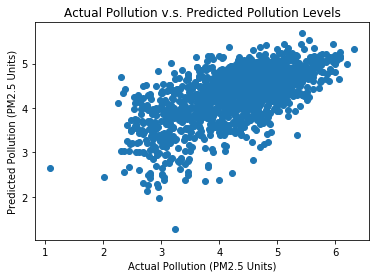

In [0]:
# Cross-Validation Scores
scores = cross_val_score(reg, dfp_daily[x], dfp_daily[y], cv=10)
print("Cross-Validation Scores: ", scores, "\n")

# Cross Validation Predictions Graph
predictions = cross_val_predict(reg, dfp_daily[x], dfp_daily[y], cv=10)
plt.scatter(dfp_daily[y], predictions)
plt.title('Actual Pollution v.s. Predicted Pollution Levels')
plt.xlabel('Actual Pollution (PM2.5 Units)')
plt.ylabel('Predicted Pollution (PM2.5 Units)')

<p>From trying out various models from shuffling the datasets between training and validation it seems there are situations in which the model's scores fairly high, but also fairly low. This may be the by-product of not having enough data especially unadjusted, accurate data on daily energy resource outputs.</p>

<h2><b>Feature Analysis Multi-Variate Regression Model</b></h2>
<p>In order to come back to the underlying purpose of training this model which was not only to see if we have the right features in place to predict pollution but also to discover what features are unneeded and which ones have a higher weight in raising pollution levels. </p>

In [0]:
# Feature Analysis
X_1 = sm.add_constant(dfp_daily[x])
#Fitting sm.OLS model
model = sm.OLS(dfp_daily[y], X_1).fit()
print(model.pvalues)

const           1.731459e-28
DEWP           8.943137e-116
TEMP           3.269249e-118
PRES            1.268470e-22
Iws             5.712478e-25
Is              3.611229e-02
Ir              5.798015e-19
coke            5.196487e-01
crude_oil       1.220786e-04
gasoline        3.927755e-15
diesel_oil      1.250507e-28
fuel_oil        5.707555e-02
natural_gas     1.385230e-27
electricity     3.144239e-27
dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<p><b>Feature Analysis Insights: </b></p>
<p>Given that alpha for our hypothesis testing is 0.05, we reject the null hypothesis of feature independence in favor of the alternate hypothesis that a feature is a predictor of pollution levels if its p-value is less than 0.05. Clearly, we can see some features are possibly independent from pollution levels e.g. crude oil and fuel oil output. <b>The energy resources which are the lowest in p-value and hence possibly affect pollution levels the most seem to be electricity, natural gas, and diesel oil</b>; although, our regression model fit scores could've been higher which means that this insight might still need more/better data and additional features. Certain energies might be more significant in shaping pollution levels simply because that is what is outputted the most. </p>

<hr>
<center>
  <h1>
    <b>
      Conclusion, and Where to Go From Here 
    </b>
  </h1>
</center>
<p>The weather data had a close link with pollution levels, specifically the precipitation and windspeed. The exploratory data analysis is important for identifying or confirming relationships like this from a high level. After getting a good idea of how the data looked, we started using a more statistical heavy analysis to try and uncover a relationship between the air pollution and production of energy sources. After thorough analysis using multiple machine learning methods, we came to a vague conclusion. The model accuracy of 51% gives reason to believe there is a relationship, but it is not reliable enough yet to make a firm claim. The energy output data is based on yearly averages, whereas the pollution data is hourly. If hourly, or even daily energy output data were to become available, we might have a much stronger model. For anyone interested in pursuing this analysis, we encourage searching for more data that could be linked to air pollution levels and try machine learning with those.</p>
<p>Thanks for reading! The sources for the web articles and datasets are listed below.</p>

<h2>Sources</h2>

jbrownlee datasets: https://github.com/jbrownlee/Datasets
<br>
Beijing datasets: https://knoema.com/atlas/China/Beijing/datasets
<br>
National Bureau of Statistic China, Major energy consumption: http://data.stats.gov.cn/english/easyquery.htm?cn=E0103
<br>
Reuters: https://www.reuters.com/article/us-china-pollution-beijing/chinas-capital-beijing-vows-air-quality-improvement-but-gives-no-target-idUSKCN1Q90TU
<br>
Blissair: https://blissair.com/what-is-pm-2-5.htm